## Create analytical set for DMSO treated profiles

Gregory Way, 2021

We collected data from many different plates in this experiment, and many of these plates contained different cell line clones and different treatments.
In this notebook, I combine the following plates and batches to form a complete dataset in which I perform downstream analyses.

The dataset contains HCT116 cell line clones that are either resistant or sensitive to bortezomib treatment.
Our hypothesis is that we can identify morphology features that consistently separate sensitive from resistant clones.

### Plates

Combine the following plates to form the final analytical dataset.

| Batch | Plate | Profiles | Treatment | Clones |
| :---- | :---- | :------- | :-------- | :----- |
| 2021_03_03_Batch12 | 219907 | 60 | 13 hour 0.1% DMSO | WT Parental, WT Clones 1-5, Resistant Clones 1-5, clone A/E |
| 2021_03_03_Batch13 | 219973 | 60 | 13 hour 0.1% DMSO | WT Parental, WT Clones 1-5, Resistant Clones 1-5, clone A/E |
| 2021_03_03_Batch14 | 219901 | 60 | 4 hour 0.1% DMSO | WT Parental, WT Clones 1-5, Resistant Clones 1-5, clone A/E |
| 2021_03_03_Batch15 | 219956 | 60 | 4 hour 0.1% DMSO | WT Parental, WT Clones 1-5, Resistant Clones 1-5, clone A/E |
| 2021_03_05_Batch16 | 220039 | 60 | 13 hour 0.1% DMSO | WT Parental, WT Clones 1-5, Resistant Clones 1-5, clone A/E |
| 2021_03_05_Batch17 | 220040 | 60 | 4 hour 0.1% DMSO | WT Parental, WT Clones 1-5, Resistant Clones 1-5, clone A/E |
| 2021_03_12_Batch18 | 220055 | 60 | 13 hour 0.1% DMSO | WT Parental, WT Clones 1-5, Resistant Clones 1-5, clone A/E |

Note we did not use batch 19 plate 220056 because of poor replicate reproducibility.

### Procedure

1. Load normalized (level 4a) profiles for the plates above
2. Split the five wildtype and and five sensitive clones into training/testing sets (85/15)
3. Keep the wildtype parental and clone A/E held out
4. Holdout one full plate (Batch 14 plate 219901 - 78 percent strong)
5. Perform feature selection using the training data only
  * Remove low variance, outlier, and blocklist features only
6. Also load the batch 3 data and add to the analytical set as full holdout, inference set

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from pycytominer import normalize, feature_select
from pycytominer.cyto_utils import infer_cp_features, write_gct

sys.path.insert(0, "../2.describe-data/scripts")
from processing_utils import load_data

In [2]:
np.random.seed(1234)

In [3]:
data_dir = pathlib.Path("../0.generate-profiles/profiles")
cell_count_dir = pathlib.Path("../0.generate-profiles/cell_counts/")

output_dir = pathlib.Path("data")

profile_suffix = "normalized.csv.gz"

feature_select_opts = [
    "variance_threshold",
    "correlation_threshold",
    "drop_na_columns",
    "blocklist",
    "drop_outliers",
]

na_cutoff = 0
corr_threshold = 0.95

test_set_size = 0.15

In [4]:
datasets = {
    "bortezomib": {
        "2021_03_03_Batch12": ["219907"],
        "2021_03_03_Batch13": ["219973"],
        "2021_03_03_Batch14": ["219901"],
        "2021_03_03_Batch15": ["219956"],
        "2021_03_05_Batch16": ["220039"],
        "2021_03_05_Batch17": ["220040"],
        "2021_03_12_Batch18": ["220055"]
    }
}

validation_plates = {
    "bortezomib": "219901"
}

In [5]:
training_clones = [
    "BZ001",
    "BZ002",
    "BZ003",
    "BZ004",
    "BZ005",
    "WT clone 01",
    "WT clone 02",
    "WT clone 03",
    "WT clone 04",
    "WT clone 05"
]

In [6]:
# Load and harmonize data for the given plates
full_df = []
for dataset in datasets:
    dataset_df = []
    validation_plate = validation_plates[dataset]
    for batch in datasets[dataset]:
        plates = datasets[dataset][batch]

        # Load and harmonize data for the given plates
        df = load_data(
            batch=batch,
            plates=plates,
            profile_dir=data_dir,
            suffix=profile_suffix,
            combine_dfs=True,
            harmonize_cols=True,
            add_cell_count=True,
            cell_count_dir=cell_count_dir
        )

        # Add important metadata features
        df = df.assign(
            Metadata_dataset=dataset,
            Metadata_batch=batch,
            Metadata_clone_type="resistant",
            Metadata_clone_type_indicator=1,
            Metadata_model_split="holdout"
        )

        df.loc[df.Metadata_clone_number.str.contains("WT"), "Metadata_clone_type"] = "sensitive"
        df.loc[df.Metadata_clone_number.str.contains("WT"), "Metadata_clone_type_indicator"] = 0
        dataset_df.append(df)

    # Merge plates of the same dataset together
    dataset_df = pd.concat(dataset_df, axis="rows", sort=False).reset_index(drop=True)
    
    # Generate a unique sample ID
    # (This will be used in singscore calculation)
    dataset_df = dataset_df.assign(
        Metadata_unique_sample_name=[f"profile_{x}_{dataset}" for x in range(0, dataset_df.shape[0])]
    )
    
    dataset_df.loc[
        dataset_df.Metadata_Plate.astype(str) == validation_plate, "Metadata_model_split"
    ] = "validation"
    
    training_df = (
        dataset_df
        .query("Metadata_model_split != 'validation'")
        .query("Metadata_clone_number in @training_clones")
    )

    train_samples, test_samples = train_test_split(
        training_df.Metadata_unique_sample_name,
        random_state=9876,
        test_size=test_set_size,
        stratify=training_df.Metadata_clone_number.astype(str)
    )
    
    dataset_df.loc[
        dataset_df.Metadata_unique_sample_name.isin(train_samples), "Metadata_model_split"
    ] = "training"
        
    dataset_df.loc[
        dataset_df.Metadata_unique_sample_name.isin(test_samples), "Metadata_model_split"
    ] = "test"
    
    full_df.append(dataset_df)

full_df = pd.concat(full_df, axis="rows", sort=False).reset_index(drop=True)

In [7]:
# Reorder features
common_metadata = infer_cp_features(full_df, metadata=True)
morph_features = infer_cp_features(full_df)

full_df = full_df.reindex(common_metadata + morph_features, axis="columns")

print(full_df.shape)
full_df.head()

(420, 3546)


,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_cell_density,Metadata_celltype_shorthand_from_plate_graph,Metadata_clone_number,Metadata_date,Metadata_plate_map_name,Metadata_time_to_adhere,...,Nuclei_Texture_Variance_RNA_10_02,Nuclei_Texture_Variance_RNA_10_03,Nuclei_Texture_Variance_RNA_20_00,Nuclei_Texture_Variance_RNA_20_01,Nuclei_Texture_Variance_RNA_20_02,Nuclei_Texture_Variance_RNA_20_03,Nuclei_Texture_Variance_RNA_5_00,Nuclei_Texture_Variance_RNA_5_01,Nuclei_Texture_Variance_RNA_5_02,Nuclei_Texture_Variance_RNA_5_03
0,219907,B02,2021_03_03_Batch12,6139,2.5x10^3 cells/well,1,WT_parental,20210205,219814,48 hr,...,-0.643064,-0.634237,-0.655460,-0.667322,-0.654629,-0.697768,-0.632006,-0.629724,-0.634584,-0.632946
1,219907,B03,2021_03_03_Batch12,4567,2.5x10^3 cells/well,2,CloneA,20210205,219814,48 hr,...,-0.830887,-0.834485,-0.830467,-0.817834,-0.830908,-0.823437,-0.834719,-0.833202,-0.832762,-0.829608
2,219907,B04,2021_03_03_Batch12,5624,2.5x10^3 cells/well,3,CloneE,20210205,219814,48 hr,...,-0.981326,-0.975970,-0.972823,-0.961743,-0.972143,-0.961802,-0.980233,-0.979095,-0.983961,-0.979349
3,219907,B05,2021_03_03_Batch12,5894,2.5x10^3 cells/well,4,WT clone 01,20210205,219814,48 hr,...,-1.086254,-1.082674,-1.068989,-1.066328,-1.057908,-1.061034,-1.090275,-1.086372,-1.088633,-1.085320
4,219907,B06,2021_03_03_Batch12,1277,2.5x10^3 cells/well,5,WT clone 02,20210205,219814,48 hr,...,1.942116,1.911892,1.981961,1.951399,2.035387,2.032162,1.920166,1.959233,1.967471,1.915364


In [8]:
pd.crosstab(full_df.Metadata_dataset, full_df.Metadata_model_split)

Metadata_model_split,holdout,test,training,validation
Metadata_dataset,,,,
bortezomib,120,36,204,60


In [9]:
pd.crosstab(full_df.Metadata_clone_number, full_df.Metadata_model_split)

Metadata_model_split,holdout,test,training,validation
Metadata_clone_number,,,,
BZ001,0,4,20,4
BZ002,0,3,21,4
BZ003,0,4,20,4
BZ004,0,4,20,4
BZ005,0,3,21,4
CloneA,24,0,0,4
CloneE,24,0,0,4
WT clone 01,0,3,21,4
WT clone 02,0,4,20,4


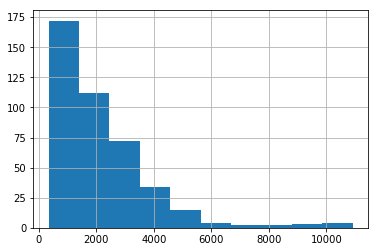

In [10]:
# We see a very large difference in cell count across profiles
# Remember that profiles were generated from averaging feature values for all single cells
full_df.Metadata_cell_count.hist()

In [11]:
selected_features = []
for dataset in datasets:
        
    # Apply feature selection
    feature_select_df = feature_select(
        profiles=(
            full_df
            .query("Metadata_dataset == @dataset")
            .query("Metadata_model_split == 'training'")
        ),
        operation=feature_select_opts,
        na_cutoff=na_cutoff,
        corr_threshold=corr_threshold
    )

    dataset_features = infer_cp_features(feature_select_df)

    selected_features.append(
        pd.DataFrame(dataset_features, columns=["features"])
        .assign(dataset=dataset)
    )
    
# Output results of feature selection
all_selected_features = pd.concat(selected_features).reset_index(drop=True)

output_file = pathlib.Path(f"{output_dir}/dataset_features_selected.tsv")
all_selected_features.to_csv(output_file, sep="\t", index=False)

print(all_selected_features.shape)
all_selected_features.head()

(782, 2)


,features,dataset
0,Cells_AreaShape_Compactness,bortezomib
1,Cells_AreaShape_Eccentricity,bortezomib
2,Cells_AreaShape_Extent,bortezomib
3,Cells_AreaShape_FormFactor,bortezomib
4,Cells_AreaShape_MeanRadius,bortezomib


In [12]:
# Load inference data (a different hold out)
inference_batch = "2019_06_25_Batch3"
inference_file = pathlib.Path(f"../3.bulk-signatures/data/{inference_batch}_combined_normalized.csv.gz")
inference_df = pd.read_csv(inference_file)

inference_df = inference_df.assign(
    Metadata_dataset="untreated_mystery_clones",
    Metadata_batch=inference_batch,
    Metadata_clone_type="resistant",
    Metadata_clone_type_indicator=1,
    Metadata_model_split="inference"
)

inference_df.loc[inference_df.Metadata_clone_number.str.contains("WT"), "Metadata_clone_type"] = "sensitive"
inference_df.loc[inference_df.Metadata_clone_number.str.contains("WT"), "Metadata_clone_type_indicator"] = 0
inference_df = inference_df.assign(
    Metadata_unique_sample_name=[f"profile_{x}_inference" for x in range(0, inference_df.shape[0])]
)

inference_df.Metadata_clone_number.value_counts()

WT_parental    6
BZ012          3
WT003          3
BZ001          3
WT005          3
WT009          3
BZ010          3
WT001          3
BZ011          3
BZ002          3
BZ015          3
BZ013          3
WT007          3
WT015          3
BZ017          3
BZ016          3
WT004          3
BZ008          3
WT010          3
BZ018          3
WT002          3
BZ003          3
BZ006          3
WT008          3
BZ009          3
WT006          3
WT014          3
WT013          3
WT012          3
BZ014          3
BZ004          3
WT011          3
BZ005          3
BZ007          3
Name: Metadata_clone_number, dtype: int64

In [13]:
# Combine profiles into a single dataset and output
bortezomib_df = pd.concat(
    [
        full_df.query("Metadata_dataset == 'bortezomib'"),
        inference_df
    ],
    axis="rows",
    sort=False
).reset_index(drop=True)

output_file = pathlib.Path(f"{output_dir}/bortezomib_signature_analytical_set.tsv.gz")
bortezomib_df.to_csv(output_file, sep="\t", index=False)

In [14]:
print(bortezomib_df.shape)
bortezomib_df.head()

(525, 3546)


,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_cell_density,Metadata_celltype_shorthand_from_plate_graph,Metadata_clone_number,Metadata_date,Metadata_plate_map_name,Metadata_time_to_adhere,...,Nuclei_Texture_Variance_RNA_10_02,Nuclei_Texture_Variance_RNA_10_03,Nuclei_Texture_Variance_RNA_20_00,Nuclei_Texture_Variance_RNA_20_01,Nuclei_Texture_Variance_RNA_20_02,Nuclei_Texture_Variance_RNA_20_03,Nuclei_Texture_Variance_RNA_5_00,Nuclei_Texture_Variance_RNA_5_01,Nuclei_Texture_Variance_RNA_5_02,Nuclei_Texture_Variance_RNA_5_03
0,219907,B02,2021_03_03_Batch12,6139,2.5x10^3 cells/well,1.0,WT_parental,20210205.0,219814,48 hr,...,-0.643064,-0.634237,-0.655460,-0.667322,-0.654629,-0.697768,-0.632006,-0.629724,-0.634584,-0.632946
1,219907,B03,2021_03_03_Batch12,4567,2.5x10^3 cells/well,2.0,CloneA,20210205.0,219814,48 hr,...,-0.830887,-0.834485,-0.830467,-0.817834,-0.830908,-0.823437,-0.834719,-0.833202,-0.832762,-0.829608
2,219907,B04,2021_03_03_Batch12,5624,2.5x10^3 cells/well,3.0,CloneE,20210205.0,219814,48 hr,...,-0.981326,-0.975970,-0.972823,-0.961743,-0.972143,-0.961802,-0.980233,-0.979095,-0.983961,-0.979349
3,219907,B05,2021_03_03_Batch12,5894,2.5x10^3 cells/well,4.0,WT clone 01,20210205.0,219814,48 hr,...,-1.086254,-1.082674,-1.068989,-1.066328,-1.057908,-1.061034,-1.090275,-1.086372,-1.088633,-1.085320
4,219907,B06,2021_03_03_Batch12,1277,2.5x10^3 cells/well,5.0,WT clone 02,20210205.0,219814,48 hr,...,1.942116,1.911892,1.981961,1.951399,2.035387,2.032162,1.920166,1.959233,1.967471,1.915364


In [15]:
assert len(bortezomib_df.Metadata_unique_sample_name.unique()) == bortezomib_df.shape[0]